# Classifying YouTube Videos for Humpback Whale Encounters - Keras CNN-RNN (ResNet50)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle
import glob
import cv2
import os
import time

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

In [3]:
# importing sys
import sys
 
# adding video-download folder to the system path
sys.path.insert(0, '/workspace/youtube-humpback-whale-classifier/video-download')
 
# importing read_frames_hdf5 function
from hdf5_data_loading import read_frames_hdf5

In [4]:
#ngc workspace path (where we keep our data)
workspace_path = '/mount/data'

# Start WandB Session

In [4]:
import wandb

#start wandb session for metric logging
wandb.login() 

wandb.init(project="whale-classification-inception")

wandb.run.name = "resnet-data-distribution"


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: micheller (epg). Use `wandb login --relogin` to force relogin


# Checking GPUs Available

In [5]:
print("Num GPUs available: ", len(tf.config.list_physical_devices('GPU'))) #1 if we select GPU mode in Colab Notebook, 0 if running on local machine

Num GPUs available:  4


# Load Dataset in + Hyperparameters

In [6]:
IMG_SIZE = 224
MAX_NUM_FRAMES = 461
NUM_FEATURES = 2048

In [7]:
#load dataset in
data = pd.read_csv(workspace_path + '/downloaded_videos.csv')
y = data.pop('relevant')
X = data

461 frames of size 224 x 224 with RGB color channels

# Load Frames + CNN Feature Extractor

In [8]:
#create CNN Feature Extractor
from cnn import CNN

ConvNet = CNN(IMG_SIZE)
feature_extractor = ConvNet.ResNet50()
feature_extractor

2022-07-21 16:14:54.908316: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 16:14:59.402163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14649 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB-N, pci bus id: 0000:85:00.0, compute capability: 7.0
2022-07-21 16:14:59.404358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14649 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB-N, pci bus id: 0000:86:00.0, compute capability: 7.0
2022-07-21 16:14:59.406350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

In [21]:
#load in frames for all videos
start = time.time()

N = X.shape[0] #number of videos in our dataset
videos = np.empty((N, 461, 224, 224, 3), dtype=np.uint8)
labels = np.empty(N, dtype = np.uint8)

for i, video in enumerate(list(X.renamed_title)):
    if i % 50 == 0:
        print(f'Loading frames for video {i}...')
    clip_name = video.replace("_", "_clip_").replace(".mp4", "")
    frames, frame_labels = read_frames_hdf5(clip_name) #returns frames array of shape (461, 224, 224, 3)
    
    videos[i, ...] = frames
    labels[i] = frame_labels[0] #all frames have the same label since label is assigned to overall video

stop = time.time()
print(f'Done loading frames in {stop-start} seconds.')
videos.shape

Loading frames for video 0...
Loading frames for video 50...
Loading frames for video 100...
Loading frames for video 150...
Loading frames for video 200...
Loading frames for video 250...
Loading frames for video 300...
Loading frames for video 350...
Done loading frames in 222.3019199371338 seconds.


(364, 461, 224, 224, 3)

`takes ~6 hours just to load in all 364 videos' frames`
`with hdf5 storage format, frames now take 117 seconds to load :)`

In [25]:
#try getting features and time
features = np.empty((N, 461, 2048), dtype=np.uint8)
start = time.time()
for i, video in enumerate(videos):
    if i % 50 == 0:
        print(f"Video {i}...")
    features[i, ...] = feature_extractor.predict_on_batch(video)

stop = time.time()
print(f"Finished extracting features from all {len(videos)} videos in {stop-start} seconds.")
features.shape

Video 0...
Video 50...
Video 100...
Video 150...
Video 200...
Video 250...
Video 300...
Video 350...
Finished extracting features from all 364 videos in 225.5248920917511 seconds.


(364, 461, 2048)

In [27]:
masks = np.ones((N, 461))
masks.shape

(364, 461)

In [26]:
labels.shape

(364,)

### Distributed Feature Extraction

In [15]:
#distribute the dataset
num_gpus = len(tf.config.list_physical_devices('GPU'))
batch_size = 1 #len(videos) // num_gpus
global_batch_size = batch_size * num_gpus

#define strategy to make use of GPUs
strategy = tf.distribute.MirroredStrategy()

#distribute tf dataset across GPUs
image_data = tf.data.Dataset.from_tensor_slices(videos[0:15]).batch(global_batch_size)
image_data_dist = strategy.experimental_distribute_dataset(image_data)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2022-07-21 16:18:12.083916: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 4
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:53"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 461
        }
        dim {
          size: 224
        }
        dim {
          size: 224
        }
        dim {
          size: 3
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        

In [16]:
num_replica_obj = 0
for x in image_data_dist:
    print(num_replica_obj)
    num_replica_obj+=1

0


In [17]:
@tf.function
def get_features(x):
    #only processes one set of video frames at a time (shape: [1, 461, 224, 224, 3])
    return feature_extractor(tf.squeeze(x), training=False) 

i=0
start = time.time()
features = []

#goes through each global-sized batch of data (ReplicaObject) and distributes it via strategy.run()
#Note: to run in Graph Exec mode, batch_size is set to 1 currently. Otherwise code runs Eager Exec (slower)
for x in image_data_dist: 
    print(i, type(x)); i+=1;
    features.append(strategy.run(get_features, args=(x,)))

stop = time.time()
print(f'\nDone extracting features in {stop-start} seconds.')

0 <class 'tensorflow.python.distribute.values.PerReplica'>

Done extracting features in 7.775835990905762 seconds.


In [73]:
# turn PerReplica objects into list of tensors
# Replica:{0:<tensor>, 1:<feature-tensor>, 2:<feature-tensor>, 3:<feature-tensor>}
feature_tensors = []
for replica_obj in features:
    feature_tensors += list(replica_obj.values) #convert tuple to list for += list operation

#converts list of tensors to list of frame features arrays
#final shape: (num_videos, 461, 2048)
features_numpy = []
for tensor in feature_tensors:
    features_numpy.append(tensor.numpy())

# #convert list to numpy format
features_numpy = np.array(features_numpy)

#print output shape
print(features_numpy.shape)
# features_numpy #these will be the input features for our CNN 

(8, 461, 2048)


### Single-GPU Feature Extraction

In [10]:
# from feature_extraction import load_frames, prepare_all_videos
from cnn import CNN

#create CNN Feature Extractor
ConvNet = CNN(IMG_SIZE)
feature_extractor = ConvNet.ResNet50()
feature_extractor

94781440/94765736 [==============================] - 2s 0us/step


In [11]:
#begin keeping track of time to extract ALL frames using a single GPU
start = time.time()

with tf.device('/device:GPU:0'):
    (frame_features, frame_masks), labels = prepare_all_videos(X, y, MAX_NUM_FRAMES, NUM_FEATURES, feature_extractor)
    
stop = time.time()

print(f"Time to extract frames with single GPU: {stop - start}s")

video_0000.mp4


2022-07-13 14:12:30.869519: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


Time to extract frames with single GPU: 288.7691180706024s


In [14]:
#took 5 hours to extract features from frames with the GPU context set above
(stop-start)/60/60

0.08021364390850066

In [15]:
print('Frame features shape: ', frame_features.shape)
print('Frame masks shape: ', frame_masks.shape)
print('Number of Labels: ', len(labels))

Frame features shape:  (5, 461, 2048)
Frame masks shape:  (5, 461)
Number of Labels:  5


# Training RNN Sequence Model

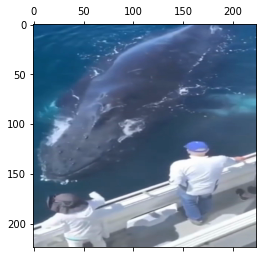

In [61]:
features[0].shape

import matplotlib.pyplot as plt
plt.matshow(videos[7, 350, :, :, :]) #350th frame of video 7

In [29]:
from sklearn.model_selection import train_test_split

#split data into 80% train, 20% test. Both test and train contain balanced class proportions (half rel, half not rel) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [30]:
from rnn import RNN
from sklearn import metrics

rnn_model = RNN()

train_index = list(X_train.index)
test_index = list(X_test.index)

#index data accordingly
train_features, train_masks, train_labels = features[train_index], masks[train_index], np.array(labels)[train_index]
test_features, test_masks, test_labels = features[test_index], masks[test_index], np.array(labels)[test_index]

#reshape label arrays as horizontal arrays
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

#create and compile model
rnn_model.build_model(MAX_NUM_FRAMES, NUM_FEATURES)
rnn_model.compile_model(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

#train model - 20 epochs gave us 75% accuracy on train
history = rnn_model.fit(train_features, train_masks, train_labels, num_epochs=50, verbose=0)

#evaluate model on test set
loss, accuracy = rnn_model.evaluate(test_features, test_masks, test_labels)

print(f"Loss: {loss}, Accuracy: {accuracy}")

#get f1, precision, recall, support metrics
y_pred = rnn_model.predict(test_features, test_masks)
y_true = test_labels.flatten()

cm = metrics.confusion_matrix(y_true, y_pred)
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print(f"F1: {f1}, Precision: {precision}, Recall: {recall}")

3/3 [==============================] - 0s 21ms/step - loss: 0.6207 - accuracy: 0.7397
Loss: 0.6206963062286377, Accuracy: 0.7397260069847107
F1: [0.74666667 0.73239437], Precision: [0.75675676 0.72222222], Recall: [0.73684211 0.74285714]


In [32]:
from rnn import RNN
from sklearn import metrics

rnn_model = RNN()

train_index = list(X_train.index)
test_index = list(X_test.index)

MAX_SEQ_LENGTH = 461
NUM_FEATURES = 2048

# index data accordingly
train_features, train_masks, train_labels = features[train_index], masks[train_index], np.array(labels)[train_index]
test_features, test_masks, test_labels = features[test_index], masks[test_index], np.array(labels)[test_index]

# reshape label arrays as horizontal arrays
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

# create and compile model
class_vocab          = [0, 1] 
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input           = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")

x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
x                    = keras.layers.GRU(8)(x)
x                    = keras.layers.Dropout(0.4)(x)
x                    = keras.layers.Dense(8, activation="relu")(x)
output               = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

model                = keras.Model([frame_features_input, mask_input], output)

model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

# train model - 20 epochs gave us 75% accuracy on train
my_callbacks    = [keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                 patience=5,
                                                 mode="max",
                                                 min_delta = 0.01,
                                                 restore_best_weights=True)]

# Fit data to model  
history = model.fit([frame_features, frame_masks], 
                        frame_labels,
                        validation_split = 0.2,
                        callbacks = my_callbacks,
                        epochs = num_epochs,
                        verbose= verbose
                    )

# evaluate model on test set
loss, accuracy = model.evaluate([frame_features, frame_masks], frame_labels)

# get f1, precision, recall, support metrics
y_pred = rnn_model.predict(test_features, test_masks)
y_true = test_labels.flatten()
cm = metrics.confusion_matrix(y_true, y_pred)
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print(f"Loss: {loss}, Accuracy: {accuracy}")
print(f"F1: {f1}, Precision: {precision}, Recall: {recall}")

NameError: name 'optimizer' is not defined

In [97]:
#log training and validation metrics on wandb
for epoch, train_loss in enumerate(history.history['loss']):
    wandb.log({'training_loss': train_loss, "epoch": epoch})
    
for epoch, train_acc in enumerate(history.history['accuracy']):
    wandb.log({'training_accuracy': train_acc, "epoch": epoch})
    
for epoch, val_loss in enumerate(history.history['val_loss']):
    wandb.log({'val_loss': val_loss, "epoch": epoch})
    
for epoch, val_acc in enumerate(history.history['val_accuracy']):
    wandb.log({'val_accuracy': val_acc, "epoch": epoch})
    
print('Done Logging WandB metrics.')

Done Logging WandB metrics.


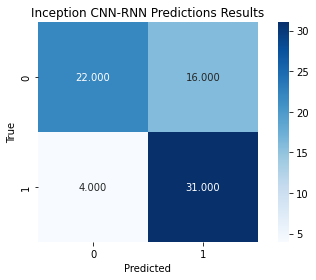

In [98]:
#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Inception CNN-RNN Predictions Results')
plt.tight_layout()

# Diving Deeper into Inference Misclassifications

- Figure out which examples got misclassified
- Put together df with Video Name, True Label, Pred Label, Video Snippet (Put frames together so we know what exact content the NN was working with - checkout DALI frame reading)
- Visualize False Positives and False Negatives on WandB as Tables

In [124]:
test_results = pd.DataFrame({'File': X.loc[test_index].renamed_title.tolist(), 
                       'True Relevant Label': y.loc[test_index].tolist(),
                       'Pred Relevant Label': list(map(bool, y_pred))})
print(test_results.shape)
test_results.head()

(73, 3)


,File,True Relevant Label,Pred Relevant Label
0,video_0241.mp4,False,False
1,video_0040.mp4,True,True
2,video_0020.mp4,True,True
3,video_0410.mp4,False,False
4,video_0071.mp4,True,True


### Plotting False Positives on WandB

In [161]:
# False Positives (True Label = 0 ; Pred Label = 1)
false_positives = test_results[(test_results["True Relevant Label"] == False) & (test_results["Pred Relevant Label"] == True)].copy(deep=True)

clip_folder = workspace_path + "/video_clips/"

#get wandb video objects
for i, row in false_positives.iterrows():
    video_clip = clip_folder + row['File'].replace('_', '_clip_')
    false_positives.at[i, ('video_clip')] = wandb.Video(video_clip, fps=4, format="gif")

#create wandb table with all information
table = wandb.Table(dataframe=false_positives)
wandb.log({"Videos Mistaken for Humpback Whales (False Postives)": table})

### Plotting False Negatives on WandB

In [162]:
# False Negatives (True Label = 1 ; Pred Label = 0)
false_negatives = test_results[(test_results["True Relevant Label"] == True) & (test_results["Pred Relevant Label"] == False)].copy(deep = True)

clip_folder = workspace_path + "/video_clips/"

#get wandb video objects
for i, row in false_negatives.iterrows():
    video_clip = clip_folder + row['File'].replace('_', '_clip_')
    false_negatives.at[i, ('video_clip')] = wandb.Video(video_clip, fps=4, format="gif")

#create wandb table with all information
table = wandb.Table(dataframe=false_negatives)
wandb.log({"Videos Mistaken as NOT Having Humpback Whales (False Negatives)": table})

# Close WandB Session

In [22]:
wandb.finish()